# Linear regression for an actual data set

We consider linear regression for an actual data set. We will use simple features of pandas (see https://pandas.pydata.org/) for data analysis.

**There are 9 questions to answer.**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# set up the random number generator: given seed for reproducibility, None otherwise
# (see https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng)
my_seed = 1
rng = np.random.default_rng(seed=my_seed)

In [3]:
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving BikeSharingDataset.csv to BikeSharingDataset.csv


# Dataset

We use the "day.csv" dataset from https://archive-beta.ics.uci.edu/dataset/275/bike+sharing+dataset (which we renamed when downloading). This dataset records daily counts of bike rentals, together with calendar information and weather conditions. In particular, the field *cnt* gives the total number of rentals that day. This is the quantity we want to predict by linear regression.

In [4]:
df = pd.read_csv('BikeSharingDataset.csv')
df.head()
df.info() # if only data types are wanted: print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


### Cleaning-up and constructing the data set

We remove the first two columns (index of element in the dataset and exact date), as well as the distinction between casual and registered users as the corresponding features are not of interest to us. See https://www.kaggle.com/code/gauravduttakiit/bike-sharing-multiple-linear-regression for further checks and manipulations to ensure that the data is correct (checking for missing data, duplicates, etc).

In [5]:
# use the drop() function in panda, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
# argument 'inplace=True' to permanently remove the column
df.drop(['instant','dteday','casual','registered'],axis=1,inplace=True)
df.head()
print(df.shape)

(731, 12)


For each rental day, the following features are provided:
 - season: 1 = spring, 2 = summer, 3 = fall, 4 = winter
 - yr: year, here 0 for 2011 and 1 for 2012
 - mnth: month, numbered from 1 to 12
 - holiday: 0 if no holiday, 1 if there is a holiday (extracted from http://dchr.dc.gov/page/holiday-schedule)
 - weekday: 0 (Sunday) to 6 (Saturday)
 - workingday: 0 for non-working day, 1 for working day
 - weathersit: weather favorability rating from 1 (clear day) to 4 (rain, fog)
 - temp: normalized temperature
 - atemp: normalized temperature feels like
 - hum: normalized humidity
 - windspeed: normalized wind speed
 - cnt: the number of rented bicycles (target attribute to be predicted)

So, we have features which are real numbers (*temp, atemp, hum,	windspeed*), binary (*holiday, workingday*), and ordinal features (eg. *season, weekday, weathersit*). We can consider all of them as real numbers features. To get some idea of the data values, we can use the panda function *describe()*, which produces some descriptive statistics (see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html).

In [6]:
df.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,4504.348837
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,1937.211452
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,3152.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,4548.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,5956.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,8714.000000


Note that the *yr* data is more or less evenly distributed (as the mean is close to 0.5). On the other hand, there are only a handful of holidays (see the small mean value of *holiday*), so this variable should probably not be considered.

We next randomly split the data into train and test sets, before conducting any analysis, as such an analysis will be based on the train set only. This is done using a dedicated scikit-learn function (see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

In [7]:
fraction_train = 0.7
fraction_test = 1.0 - fraction_train
df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 511 entries, 469 to 665
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      511 non-null    int64  
 1   yr          511 non-null    int64  
 2   mnth        511 non-null    int64  
 3   holiday     511 non-null    int64  
 4   weekday     511 non-null    int64  
 5   workingday  511 non-null    int64  
 6   weathersit  511 non-null    int64  
 7   temp        511 non-null    float64
 8   atemp       511 non-null    float64
 9   hum         511 non-null    float64
 10  windspeed   511 non-null    float64
 11  cnt         511 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 51.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 220 entries, 486 to 96
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      220 non-null    int64  
 1   yr          220 non-null    int64 

### Exploring the data

We start by exploring the dataset to understand how the target attribute (*cnt*) depends on each of the features. We start by using the plot function of *pandas* (see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html). It would be better to do this on the training data only, but we do it on the full data here.

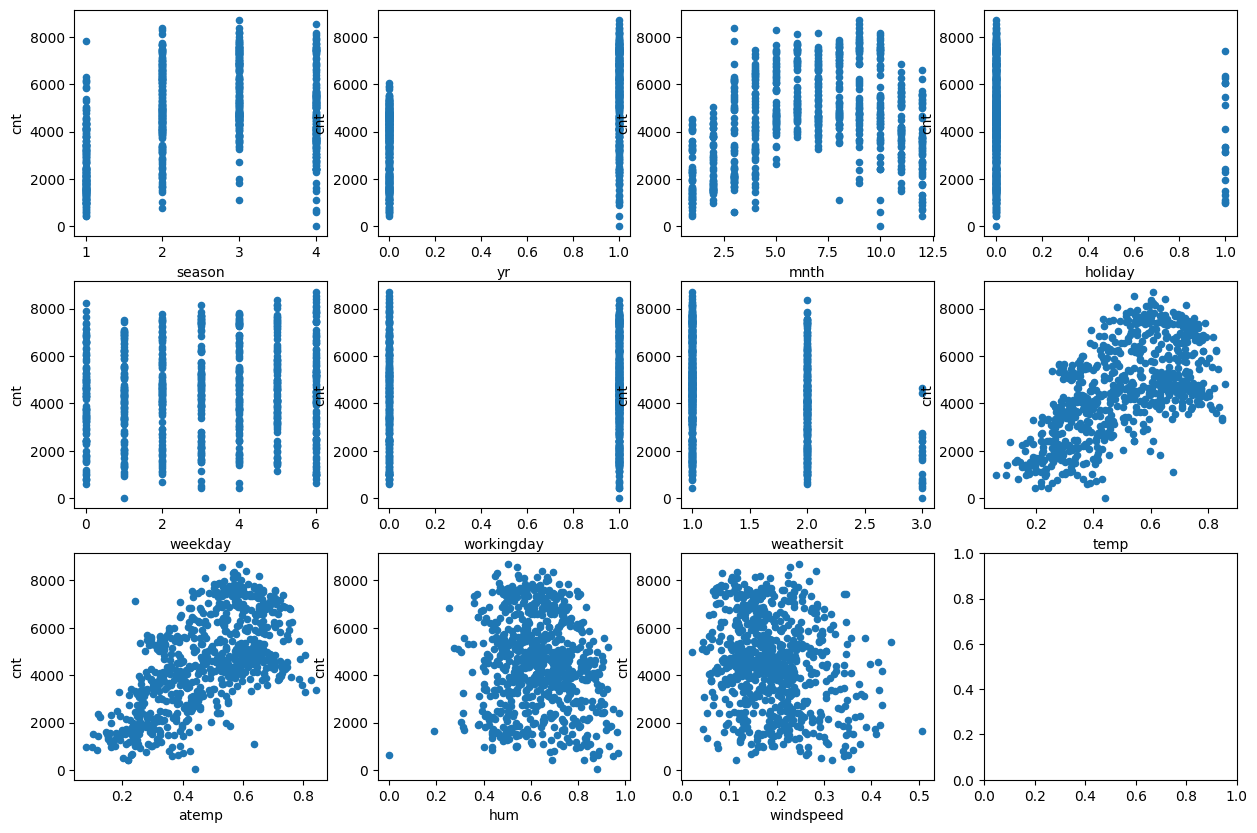

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
# df_train.columns[:-1] is the list of all columns, except the last one (the target attribute 'cnt')
# this can be enumerated with an index using https://docs.python.org/3/library/functions.html#enumerate
# position in the axes: vector [i,j] with i is the line number, and j the column index
for idx, feature in enumerate(df_train.columns[:-1]):
    df.plot(feature, "cnt", subplots=True,  kind="scatter", ax=axes[idx // 4, idx % 4])
plt.show()

It is not so easy to have some quantitative impression from scatter plots of categorical variables. Boxplots can be more appropriate.

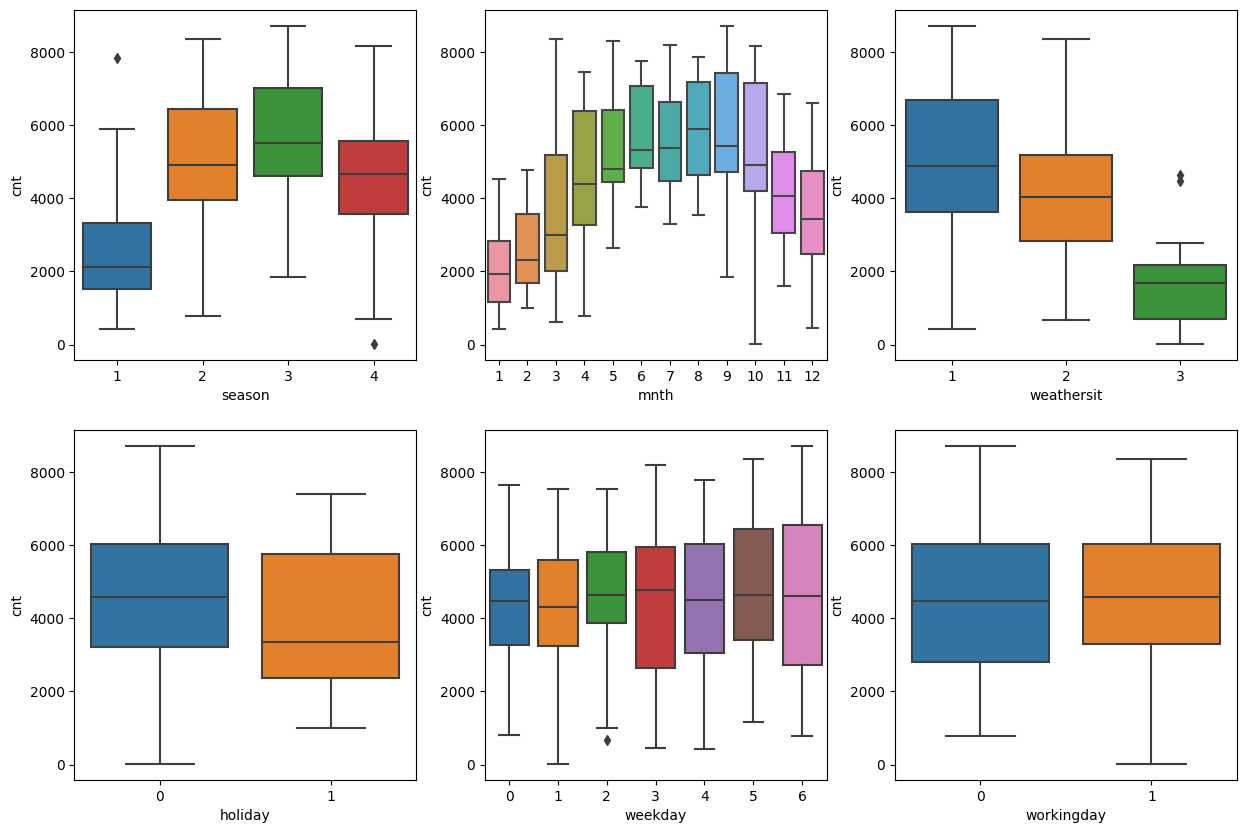

In [9]:
plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = df_train)
plt.subplot(2,3,2)
sns.boxplot(x = 'mnth', y = 'cnt', data = df_train)
plt.subplot(2,3,3)
sns.boxplot(x = 'weathersit', y = 'cnt', data = df_train)
plt.subplot(2,3,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = df_train)
plt.subplot(2,3,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = df_train)
plt.subplot(2,3,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = df_train)
plt.show()

**Question 1.** Based on these plots, describe features which have an influence on the target attribute.

The plots suggest that there is a linear dependence between the target and some features such *temp* or *atemp*. There are also noticeable correlations with *mnth* and *season*. There seems to be also more rentals on working days, and when the weather is fine.

### Data normalization

The sizes of the data entries are on rather different scales, as made precise through the output of the *describe()* function above. We therefore renormalize the data by rescaling the features, so that all entries are between 0 and 1 (see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [10]:
scaler = MinMaxScaler()
df_train[:] = scaler.fit_transform(df_train[:])
df_train.describe()

<ipython-input-10-0f8f30778279>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train[:] = scaler.fit_transform(df_train[:])


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000
mean,0.512720,0.502935,0.509340,0.029354,0.505871,0.694716,0.204501,0.543324,0.518040,0.646923,0.399359,0.518098
std,0.368417,0.500481,0.312707,0.168963,0.331972,0.460979,0.277876,0.226086,0.212174,0.148387,0.181290,0.224244
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.272727,0.000000,0.166667,0.000000,0.000000,0.349977,0.339952,0.539203,0.268540,0.362920
50%,0.666667,1.000000,0.545455,0.000000,0.500000,1.000000,0.000000,0.549345,0.535113,0.648671,0.378326,0.523125
75%,1.000000,1.000000,0.818182,0.000000,0.833333,1.000000,0.500000,0.740406,0.694251,0.754499,0.498111,0.691498
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The minimum and maximum are indeed 0 and 1 for all variables.

### Features and target correlations

We now estimate more quantitatively the level of linear dependence between the features and the target variable. A good measure of the linear relationship between two vectors is the [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) (see also Chapter 25 [Shalev-Shwartz] for a discussion on how it relates to feature selection).

Correlations can also be computed with the *pandas* library, using the dataframe method *corr* (see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html), and plotted with the heatmap function of the statistical data visualization library *seaborn* (see https://seaborn.pydata.org/generated/seaborn.heatmap.html)/

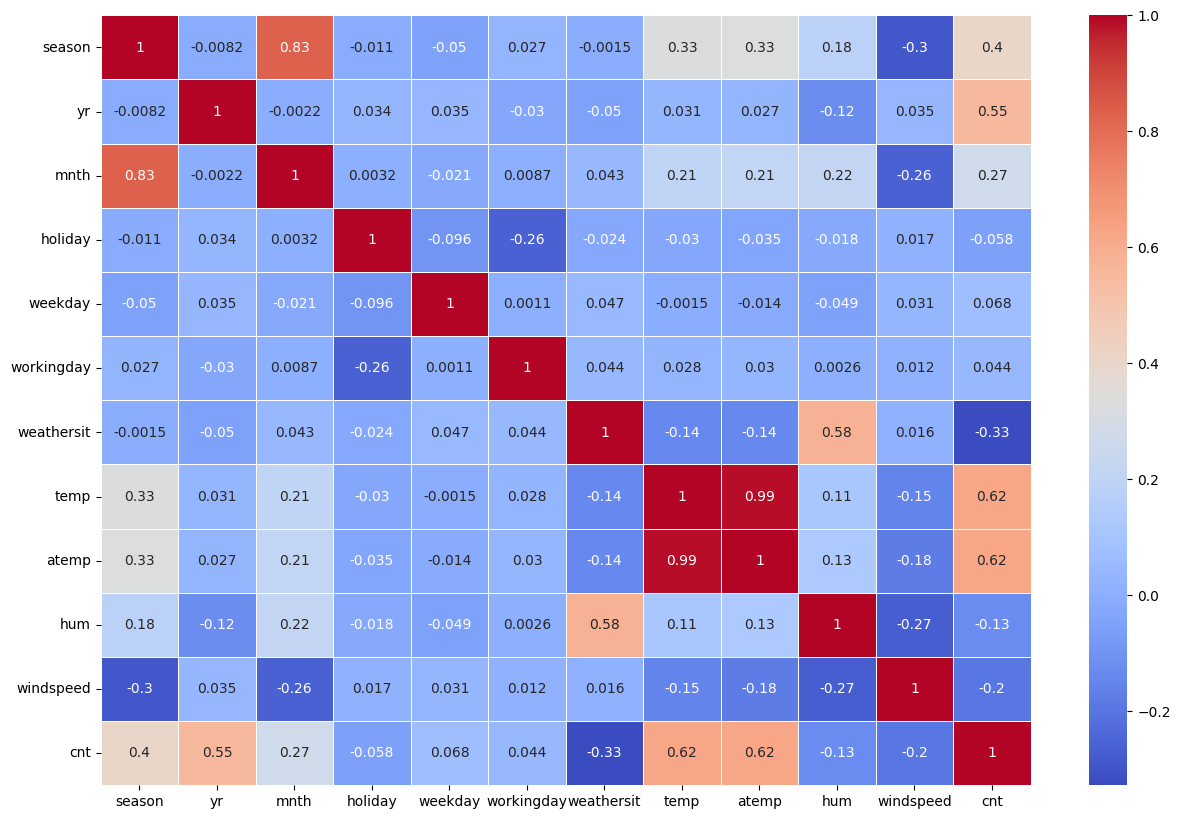

In [11]:
plt.figure(figsize = (15,10))
# sns.set_theme()
# other 'Diverging colormaps' can be used, see https://matplotlib.org/stable/tutorials/colors/colormaps.html
sns.heatmap(df_train.corr(method='pearson'), annot = True, linewidths=.5, cmap="coolwarm")
plt.show()

We next break down the correlations into correlations between the variables we are looking for to predict the result, and correlations between these variables and the target attribute *cnt*. The latter correlations can be computed with the function *corrwith* (see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corrwith.html), which needs as argument another dataframe as an argument to compute the pairwise correlations with.

In [12]:
# df_train_variables is df_train without the column of the target attribute 'cnt'
# alternative command: use df[df.columns.difference(['cnt'])]
df_train_variables = df_train[df_train.columns[:-1]]
# get features correlation coefficients
df_train_variables.corr(method='pearson')

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
season,1.000000,-0.008179,0.830999,-0.011260,-0.049599,0.026759,-0.001518,0.326705,0.334421,0.183231,-0.295944
yr,-0.008179,1.000000,-0.002169,0.033760,0.035301,-0.030104,-0.050147,0.031296,0.027314,-0.124501,0.035039
mnth,0.830999,-0.002169,1.000000,0.003235,-0.020848,0.008690,0.043107,0.205416,0.212229,0.221030,-0.263795
holiday,-0.011260,0.033760,0.003235,1.000000,-0.096298,-0.262335,-0.023701,-0.029677,-0.034562,-0.018073,0.016918
weekday,-0.049599,0.035301,-0.020848,-0.096298,1.000000,0.001057,0.047184,-0.001473,-0.013520,-0.048590,0.031225
workingday,0.026759,-0.030104,0.008690,-0.262335,0.001057,1.000000,0.044424,0.027960,0.029758,0.002649,0.012382
weathersit,-0.001518,-0.050147,0.043107,-0.023701,0.047184,0.044424,1.000000,-0.140597,-0.139088,0.584311,0.015992
temp,0.326705,0.031296,0.205416,-0.029677,-0.001473,0.027960,-0.140597,1.000000,0.989297,0.114704,-0.153545
atemp,0.334421,0.027314,0.212229,-0.034562,-0.013520,0.029758,-0.139088,0.989297,1.000000,0.127410,-0.180137
hum,0.183231,-0.124501,0.221030,-0.018073,-0.048590,0.002649,0.584311,0.114704,0.127410,1.000000,-0.271569


Some quantities are strongly correlated (in particular *temp* and *atemp*). This will require some care when choosing the features for prediction.

We next compute correlations with the target attribute.

In [13]:
df_train_variables.corrwith(df_train['cnt'], axis=0, method='pearson')

season        0.403458
yr            0.549203
mnth          0.268422
holiday      -0.057554
weekday       0.068487
workingday    0.044156
weathersit   -0.328307
temp          0.621445
atemp         0.622501
hum          -0.127443
windspeed    -0.195295
dtype: float64

**Question 2.** Compare these numbers with the corresponding ones in the heatmap above.

We recover the numbers displayed in the heatmap above.

The sample above shows features correlations with the target. Some of them (in fact, all of of them) are not *null*. This means that it makes sense to try to predict the output using a linear method (although in the end it may not be sufficient).

# Training with all features (despite strong correlations)

Some attributes in our dataset have strong correlations (one speaks of *multicollinearity*, see https://en.wikipedia.org/wiki/Multicollinearity), which can lead to issues in solving the regression problem, as the design matrix may be ill-conditioned. We start by a naive estimation where we pretend that we have not noticed the strong correlations, in order to highlight the kind of problems that arise.

We start by decomposing the train data into the features $X$ and the target attribute $y$.

In [14]:
# from sklearn.utils import shuffle
# df_shuffled = shuffle(df, random_state=123)
df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
df_train[:] = scaler.fit_transform(df_train[:])
X = df_train[df_train.columns[:-1]]
y = df_train["cnt"]
df_test[:] = scaler.transform(df_test[:])
X_test = df_test[df_test.columns[:-1]]
y_test = df_test["cnt"]
print(X.head())
print('\n------------------------------------\n')
print(y.head())

       season   yr      mnth  holiday   weekday  workingday  weathersit  \
327  1.000000  0.0  0.909091      1.0  0.666667         0.0         0.0   
553  0.666667  1.0  0.545455      0.0  1.000000         0.0         0.0   
460  0.333333  1.0  0.272727      0.0  0.666667         1.0         0.0   
502  0.333333  1.0  0.363636      0.0  0.666667         1.0         0.0   
430  0.000000  1.0  0.181818      0.0  0.333333         1.0         0.0   

         temp     atemp       hum  windspeed  
327  0.391512  0.404221  0.460436   0.261829  
553  1.000000  1.000000  0.387679   0.253691  
460  0.468352  0.485082  0.237387   0.375161  
502  0.665643  0.679959  0.423261   0.396744  
430  0.248216  0.242439  0.342539   0.334680  

------------------------------------

327    0.127402
553    0.531730
460    0.727185
502    0.839236
430    0.424876
Name: cnt, dtype: float64


<ipython-input-14-6110698be445>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train[:] = scaler.fit_transform(df_train[:])
<ipython-input-14-6110698be445>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_test[:] = scaler.transform(df_test[:])


**Question 3.** Check that the test data has been properly normalized. Are the minima and maxima of all features 0 and 1, respectively? If not, why?

In [15]:
df_test.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.431818,0.483884,0.040909,0.508333,0.654545,0.193182,0.550396,0.553978,0.555973,0.299893,0.477869
std,0.360636,0.496459,0.307036,0.198531,0.338703,0.476601,0.278939,0.235857,0.233563,0.181521,0.161763,0.231040
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047675,0.053538,-0.239512,-0.052642,-0.050647
25%,0.250000,0.000000,0.181818,0.000000,0.166667,0.000000,0.000000,0.347641,0.343768,0.438927,0.186588,0.297625
50%,0.333333,0.000000,0.454545,0.000000,0.500000,1.000000,0.000000,0.563363,0.585125,0.552575,0.297572,0.482957
75%,0.666667,1.000000,0.727273,0.000000,0.833333,1.000000,0.500000,0.753645,0.742582,0.692910,0.398446,0.654297
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.984424,1.049574,0.987254,0.856992,0.980781


We use the rescaling of the train data. It is therefore possible that some features in the test do not span all the values between 0 and 1 (for instance, the minimum can be below 0; or the maximum below 1).

### Plain training of a linear model

We first do some training on the whole data set, with all features kept.

**Question 4.** Train a linear regression model on the training dataset and look at the feature weights. The acquired weights are in the *coef_* parameter of a regressor class. It is good to re-run the estimation several times by randomly re-splitting the data set into train and test sets. What do you observe?

In [16]:
from sklearn import linear_model
# build a model
linear_regressor = linear_model.LinearRegression()
# train the model using all data
linear_regressor.fit(X, y)
# output coefficients
print('\nCoefficients and their weights:')
# zip function to aggregate https://docs.python.org/3.3/library/functions.html#zip
# "{:.3f}".format(number) to display number with 3 decimal places
# or alternatively round(number,3), as used below
for pair in zip(df_train.columns, linear_regressor.coef_):
  print(pair[0],' -> ',"{:.3f}".format(pair[1]))


Coefficients and their weights:
season  ->  0.187
yr  ->  0.245
mnth  ->  -0.053
holiday  ->  -0.049
weekday  ->  0.064
workingday  ->  0.025
weathersit  ->  -0.145
temp  ->  0.100
atemp  ->  0.428
hum  ->  -0.125
windspeed  ->  -0.146


We see that the weights for linearly dependent features are significantly greater in absolute values than for other features. More importantly, when re-running the fitting procedure with newly randomly split train/test sets, the weights for these features change dramatically (look for instance at *temp* and *atemp*; although, interestingly, the sums of these weights is more or less constant) -- as opposed to other weights, such as *yr*, which are quite stable. This is related to the fact that the matrix $X^T X$ is ill-conditioned when two features are too strongly correlated, so that the linear system $X^T X w = X^T y$ defining $w$ is difficult to solve, in the sense that small variations in $y$ can lead to strong variations in $w$.

For the remainder of this notebook, we remove the *temp* field, and only keep *atemp*.

In [17]:
df.drop('temp',axis=1,inplace=True)

# Training with some regularization
We next consider training with some regularization in order to obtain the best bias/variance trade-off. The norm of weights multiplied by the regularization coefficient $\alpha$ is added to the cost function to minimize. We consider both lasso ($\ell^1$ norm) and ridge ($\ell^2$ norm) regression. We train the associated regularized cost functions with their defaults parameters, see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html and https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [18]:
from sklearn.linear_model import Lasso, Ridge

### One shot training

We can run the optimization with lasso and ridge regression various times, by randomly reshuffling the data set in order to get some intuition on the variability of the coefficients. We work here only on the training data, and do not test yet the quality of the prediction on the test set.

**Question 5.** Change the value of the regularization parameter $\alpha$ in order to see the impact on the fitted coefficients. What do you observe?

In [19]:
lasso = Lasso(alpha=0.01)
df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
df_train[:] = scaler.fit_transform(df_train[:])
X = df_train[df_train.columns[:-1]]
y = df_train["cnt"]
lasso.fit(X, y)
print('Intercept -> ', round(lasso.intercept_,3))
for pair in zip(df_train.columns, lasso.coef_):
  print(pair[0],' -> ',"{:.3f}".format(pair[1]))

Intercept ->  0.197
season  ->  0.109
yr  ->  0.199
mnth  ->  0.000
holiday  ->  -0.000
weekday  ->  0.000
workingday  ->  0.000
weathersit  ->  -0.065
atemp  ->  0.354
hum  ->  -0.000
windspeed  ->  -0.000


<ipython-input-19-a3be8038a064>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train[:] = scaler.fit_transform(df_train[:])


For large values of $\alpha$, many coefficients are 0, and the non zero coefficients are rather stable from one realization of the test/train split to the other. For small values of $\alpha$, almost all coefficients are non zero, and can substantially change from one realization to another.

**Question 6.** Do the same for ridge regression.

In [20]:
ridge = Ridge(alpha=0.0001)
ridge.fit(X, y)
print('Intercept -> ', round(ridge.intercept_,3))
for pair in zip(df_train.columns, ridge.coef_):
  print(pair[0],' -> ',"{:.3f}".format(pair[1]))

Intercept ->  0.146
season  ->  0.180
yr  ->  0.232
mnth  ->  -0.049
holiday  ->  -0.060
weekday  ->  0.059
workingday  ->  0.011
weathersit  ->  -0.142
atemp  ->  0.524
hum  ->  -0.091
windspeed  ->  -0.091


The coefficients for ridge regression and lasso are quite similar for small values of the regularization parameter. A nice aspect of lasso regression though is that it puts to 0 uninformative features, whereas ridge regression still assigns them a non zero (although small) coefficient.

### Training paths

We now explore more systematically the dependence of the result as a function of the regularization coefficient. The aim is to find the best value of $\alpha$ for prediction, using the test set. Before doing this, we look more closely at how the coefficients of the fit change as $\alpha$ is increased.

For each coefficient value from the vector of values *alphas_lasso* for the parameter $\alpha$, we train the Lasso regressor and write the weights into the corresponding rows of the *coefs_lasso* matrix. The same is then done for ridge regression. This will allow us to look at how coefficients vary as $\alpha$ is changed. Note that it would be possible instead to plot results as a function of the magnitude of the coefficients, using the scikit-learn function https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.lars_path.html

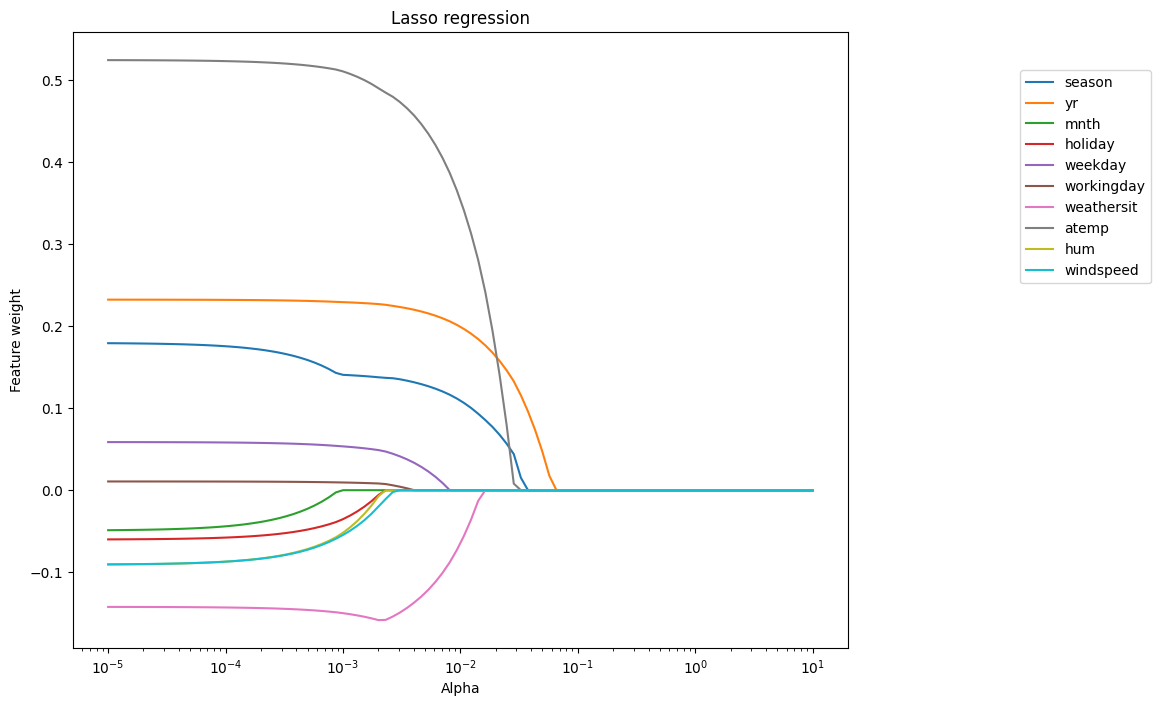

In [21]:
# we use coefficients logarithmically spaced in order to cover a wide range of values
alphas_lasso = np.logspace(-5, 1, 100)
coefs_lasso = np.zeros((alphas_lasso.shape[0], X.shape[1]))

for i, al in enumerate(alphas_lasso):
    lasso = Lasso(alpha = al)
    lasso.fit(X, y)
    for j, coef in enumerate(lasso.coef_):
        coefs_lasso[i][j] = coef

plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.semilogx(alphas_lasso, coef, label=feature)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("Alpha")
plt.ylabel("Feature weight")
plt.title("Lasso regression")
plt.show()

We next do the same for ridge regression.

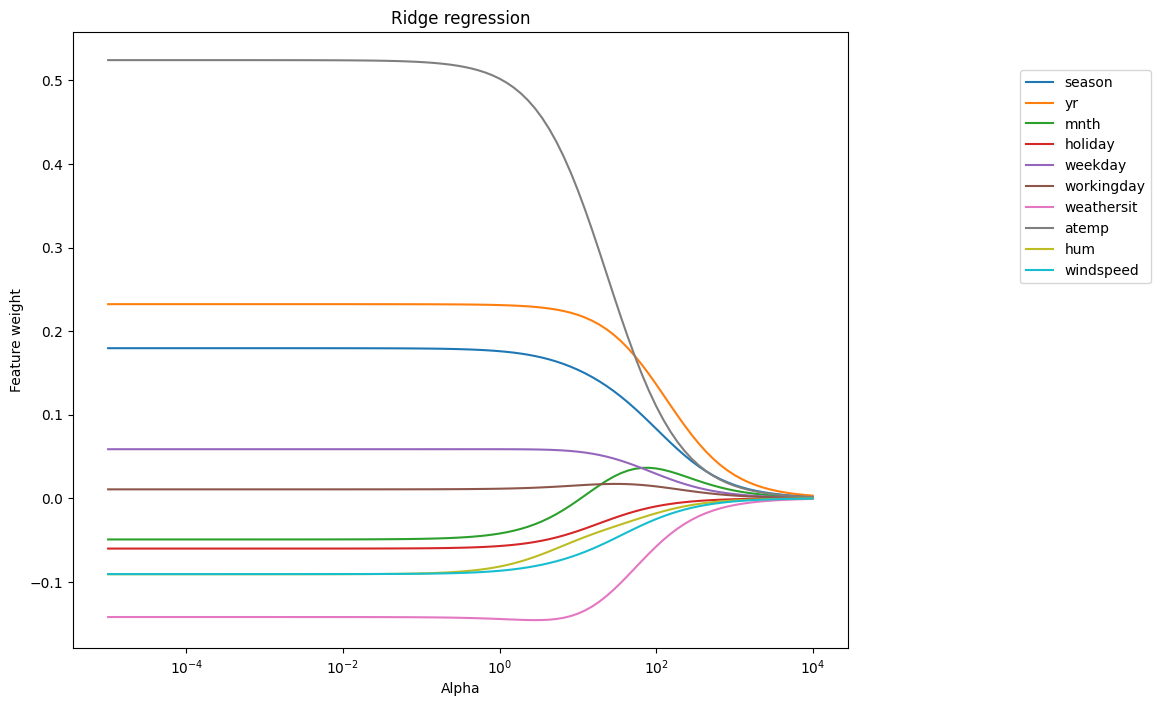

In [22]:
alphas_ridge = np.logspace(-5, 4, 100)
coefs_ridge = np.zeros((alphas_ridge.shape[0], X.shape[1]))

for i, al in enumerate(alphas_ridge):
    ridge = Ridge(alpha = al)
    ridge.fit(X, y)
    for j, coef in enumerate(ridge.coef_):
        coefs_ridge[i][j] = coef

plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.semilogx(alphas_ridge, coef, label=feature)
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("Alpha")
plt.ylabel("Feature weight")
plt.title("Ridge regression")
plt.show()

For illustration, we can also compute the regression path as a function of the magnitude of the coefficients, for lasso.

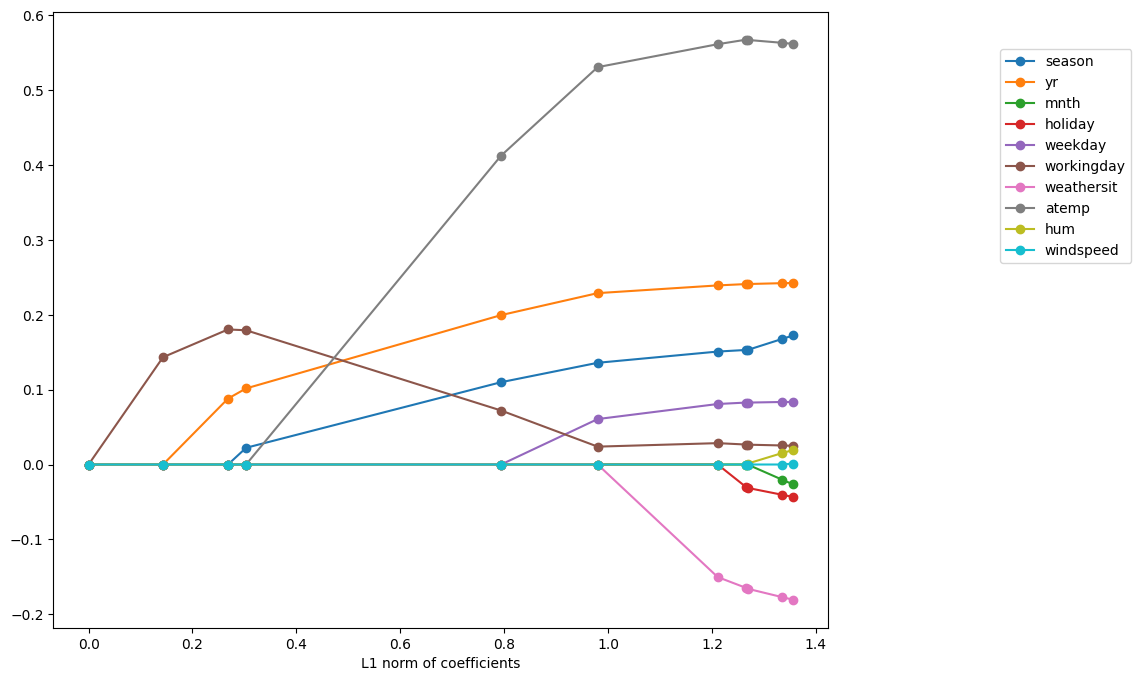

In [23]:
# dataframes need to be converted to numpy format
XX = X.to_numpy()
yy = y.to_numpy()
_, _, coefs = linear_model.lars_path(XX, yy, method="lasso")

# plot the corresponding result
tau = np.sum(np.abs(coefs.T), axis=1)
plt.figure(figsize=(10, 8))
plt.xlabel("L1 norm of coefficients")
plt.plot(tau, coefs.T, marker="o")
plt.legend(list(df.columns), bbox_to_anchor=(1.4, 0.95))
plt.show()

**Question 7.** What are the largest coefficients? Which coefficients are the most important? (in the sense that they are non zero first when performing lasso)

Note that, in all these plots, the coefficient for the year is large and positive, and is the first one to be non zero when decreasing the penalty coefficient (starting from a large value). This is because there were more rentals in average in the second year (as we check below; see the last column 'cnt' in the reported statistics). The average of the other features are rather similar. This could be due to the fact that the bike rental system was better known the second year, and therefore attracted more customers, irrespectively of weather conditions, etc.

The coefficient related to the working day is the first one to be non zero when looking at the LARS path, but it eventually converges to a rather small value.

Moreover, the coefficient corresponding to temperature is large, and, to a lesser extent, the one related to the season.

In [24]:
df_0 = df[df["yr"] == 0]
df_1 = df[df["yr"] == 1]
print('Statistics for the first year \n')
print(df_0.describe())
print('\n ------------------------------ \n')
print('Statistics for the second year \n')
print(df_1.describe())

Statistics for the first year 

           season     yr        mnth     holiday     weekday  workingday  \
count  365.000000  365.0  365.000000  365.000000  365.000000  365.000000   
mean     2.498630    0.0    6.526027    0.027397    3.008219    0.684932   
std      1.110946    0.0    3.452584    0.163462    2.006155    0.465181   
min      1.000000    0.0    1.000000    0.000000    0.000000    0.000000   
25%      2.000000    0.0    4.000000    0.000000    1.000000    0.000000   
50%      3.000000    0.0    7.000000    0.000000    3.000000    1.000000   
75%      3.000000    0.0   10.000000    0.000000    5.000000    1.000000   
max      4.000000    0.0   12.000000    1.000000    6.000000    1.000000   

       weathersit       atemp         hum   windspeed          cnt  
count  365.000000  365.000000  365.000000  365.000000   365.000000  
mean     1.421918    0.466835    0.643665    0.191403  3405.761644  
std      0.571831    0.168836    0.148744    0.076890  1378.753666  
min    

### Cross validation

We next perform cross validation in order to choose the best coefficient. The metric for the quality of the results is the mean square error (MSE) computed on the test set. We explore two approaches: randomly splitting the full data set into test/train sets, or using k-fold cross validation. For the latter method, we use built-in routines in scikit-lean to divide the sample into $k$ blocks, each of them being considered as a test set when training is performed on the remaining $k-1$ blocks. The MSE for a given value of $\alpha$ is averaged over the test MSEs over the folds.

We start by computing the MSE and the regression score for a given value of $\alpha$ in a pedestrian way, in order to get a feeling for what is being done. Everything is done for Lasso, but the adaptation to ridge regression would be straightforward.

**Question 8.** Complete the code below: in one case, you need to compute 'by hand' something computed by a built-in scikit-learn function, and in the other case you need on the contrary to use a built-in scikit-learn function.

Intercept: 0.14396170408899178
Rounded coef: [0.152, 0.259, -0.023, -0.056, 0.037, 0.019, -0.155, 0.543, -0.115, -0.154]

R2  (train) =  0.8163901012255486
R2  (train) =  0.8163901012255486  computed by hand
MSE (train) =  0.010487703238535985
MSE (train) =  0.010487703238535985  computed by hand

R2   (test) =  0.7460571749476539
MSE  (test) =  0.01245682391284063


<ipython-input-25-4cc7e74e788d>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train[:] = scaler.fit_transform(df_train[:])
<ipython-input-25-4cc7e74e788d>:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_test[:] = scaler.transform(df_test[:])


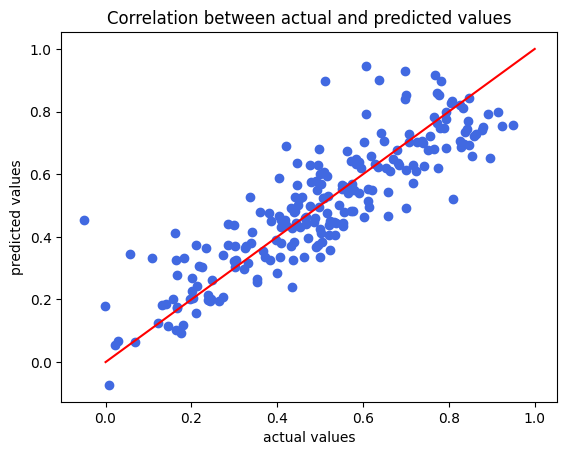

In [25]:
al = 0.0001

df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
df_train[:] = scaler.fit_transform(df_train[:])
X = df_train[df_train.columns[:-1]]
y = df_train["cnt"]
df_test[:] = scaler.transform(df_test[:])
X_test = df_test[df_test.columns[:-1]]
y_test = df_test["cnt"]

lasso = Lasso(alpha = al)
lasso.fit(X, y)
# report coefficients
print('Intercept:', lasso.intercept_)
print( 'Rounded coef:', list(map(lambda c: round(c, 3) , lasso.coef_) ))
# see function score() on https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
print('\nR2  (train) = ',lasso.score(X,y))
y_pred = lasso.predict(X)
E2_test = ((y-y_pred)**2).sum()
print('R2  (train) = ',1-E2_test/sum( (y-np.mean(y))**2 ),' computed by hand')
# we next compute the MSE equivalently
from sklearn.metrics import mean_squared_error
print('MSE (train) = ',mean_squared_error(lasso.predict(X), y))
print('MSE (train) = ',((y-lasso.predict(X))**2).mean(),' computed by hand\n')
# compute the prediction error on the test set
# one can check that this is equivalent to lasso.intercept_+sum(lasso.coef_*X[i]) for each index i
y_pred = lasso.predict(X_test)
print('R2   (test) = ',lasso.score(X_test,y_test))
print('MSE  (test) = ',((y_test-y_pred)**2).mean())
# plotting the results
plt.title('Correlation between actual and predicted values')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.scatter(y_test,y_pred,color='royalblue')
plt.plot([0,1],[0,1],color='red')
plt.show()

We now more precisely quantify the variability of the outputs by performing several realizations.

In [26]:
al = 0.0001
nb_real = 100

R2_test = np.zeros(nb_real)
MSE_test = np.zeros(nb_real)

lasso = Lasso(alpha = al)
for real in range(nb_real):
  df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
  df_train[:] = scaler.fit_transform(df_train[:])
  X_train = df_train[df_train.columns[:-1]]
  y_train = df_train["cnt"]
  lasso.fit(X, y)
  df_test[:] = scaler.transform(df_test[:])
  X_test = df_test[df_test.columns[:-1]]
  y_test = df_test["cnt"]
  R2_test[real] = lasso.score(X_test,y_test)
  # equivalently one could use a built-in function:
  # import function as --> from sklearn.metrics import mean_squared_error
  # call function as --> mean_squared_error(y_pred, y)
  # with y_pred = lasso.predict(X)
  MSE_test[real] = ((y_test-lasso.predict(X_test))**2).mean()

print('Average R2  (test) =', R2_test.mean())
print('Average MSE (test) =', MSE_test.mean())

<ipython-input-26-a97c4c71ddf9>:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train[:] = scaler.fit_transform(df_train[:])
<ipython-input-26-a97c4c71ddf9>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_test[:] = scaler.transform(df_test[:])
<ipython-input-26-a97c4c71ddf9>:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetite

Average R2  (test) = 0.7797474958854024
Average MSE (test) = 0.011140425080390511


<ipython-input-26-a97c4c71ddf9>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_test[:] = scaler.transform(df_test[:])


In practice, one rather uses a single data set, and relies on built-in cross validation function such as [__LassoCV__](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). It takes as input a list of values of $\alpha$ and calculates the MSE for each of them. After training, the regressor will contain the variable __mse\_path\___, a matrix of size `len(alpha) x n_folds`, where `n_folds` (the number of blocks in cross-validation), containing the MSE values on the test for the corresponding runs. In addition, the variable __alpha\___ will store the selected (optimal) value of the regularization parameter, and in __coef\___, will have the trained weights corresponding to this __alpha___.

Note that the regressor can change the order in which it iterates through the alphas values. In order to map it to the MSE matrix, it is better to use the regressor variable __alphas___.

In [27]:
from sklearn.linear_model import LassoCV

In [28]:
df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
df_train[:] = scaler.fit_transform(df_train[:])
X_train = df_train[df_train.columns[:-1]]
y_train = df_train["cnt"]

alphas_lasso = np.logspace(-7, -3, 500)
nb_folds = 10
reg = LassoCV(cv=nb_folds, alphas = alphas_lasso)
reg.fit(X, y)
print('Regularizator score (R2 coefficient):', reg.score(X, y))
print('Regularizator\'s optimal alpha value:', reg.alpha_)
print('Regularizator coefficients:')
[(pair[0], round(pair[1], 4)) for pair in zip(df.columns[:-1], reg.coef_)]

<ipython-input-28-80e73adba5b0>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train[:] = scaler.fit_transform(df_train[:])


Regularizator score (R2 coefficient): 0.8164338605466336
Regularizator's optimal alpha value: 1.0186289902446865e-07
Regularizator coefficients:


[('season', 0.156),
 ('yr', 0.2588),
 ('mnth', -0.0282),
 ('holiday', -0.059),
 ('weekday', 0.0373),
 ('workingday', 0.0194),
 ('weathersit', -0.154),
 ('atemp', 0.5452),
 ('hum', -0.122),
 ('windspeed', -0.1591)]

We can plot the MSE as a function of $\alpha$ to check how much is gained in the cross validation process.

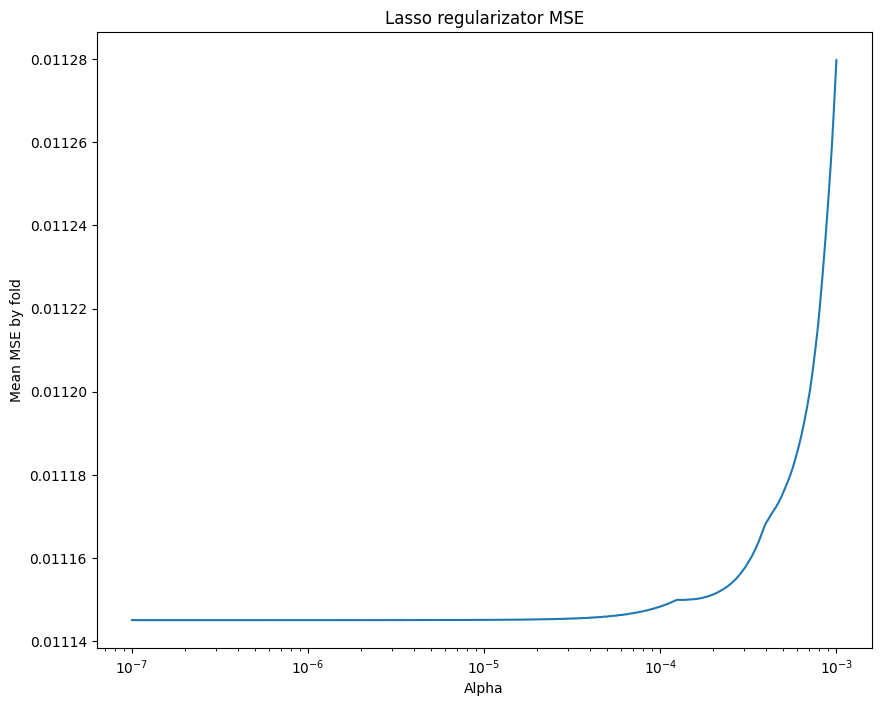

In [29]:
mean_mse_arr = np.array(reg.mse_path_).mean(axis=1)
plt.figure(figsize=(10, 8))
plt.semilogx(reg.alphas_, mean_mse_arr, label=feature )
plt.xlabel("Alpha")
plt.ylabel("Mean MSE by fold")
plt.title("Lasso regularizator MSE")
#plt.ylim(0.011869,0.011872)
plt.show()

In [30]:
# use cross validation for ridge regression
# see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html
from sklearn.linear_model import RidgeCV

In [31]:
df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test)
df_train[:] = scaler.fit_transform(df_train[:])
X_train = df_train[df_train.columns[:-1]]
y_train = df_train["cnt"]

alphas_ridge = np.logspace(-5, 1, 500)
# doing "leave one out cross validation" by default
reg = RidgeCV(cv=None, alphas = alphas_ridge, scoring=None, store_cv_values=True)
reg.fit(X, y)
print('Regularizator score (R2 coefficient):', reg.score(X, y))
print('Regularizator\'s optimal alpha value:', reg.alpha_)
print('Regularizator coefficients:')
[(pair[0], round(pair[1], 4)) for pair in zip(df.columns[:-1], reg.coef_)]

Regularizator score (R2 coefficient): 0.8163494997082527
Regularizator's optimal alpha value: 0.37079876291681724
Regularizator coefficients:


<ipython-input-31-67c1625d1890>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train[:] = scaler.fit_transform(df_train[:])


[('season', 0.1557),
 ('yr', 0.2585),
 ('mnth', -0.0264),
 ('holiday', -0.0576),
 ('weekday', 0.0374),
 ('workingday', 0.0197),
 ('weathersit', -0.1563),
 ('atemp', 0.5359),
 ('hum', -0.1132),
 ('windspeed', -0.1545)]

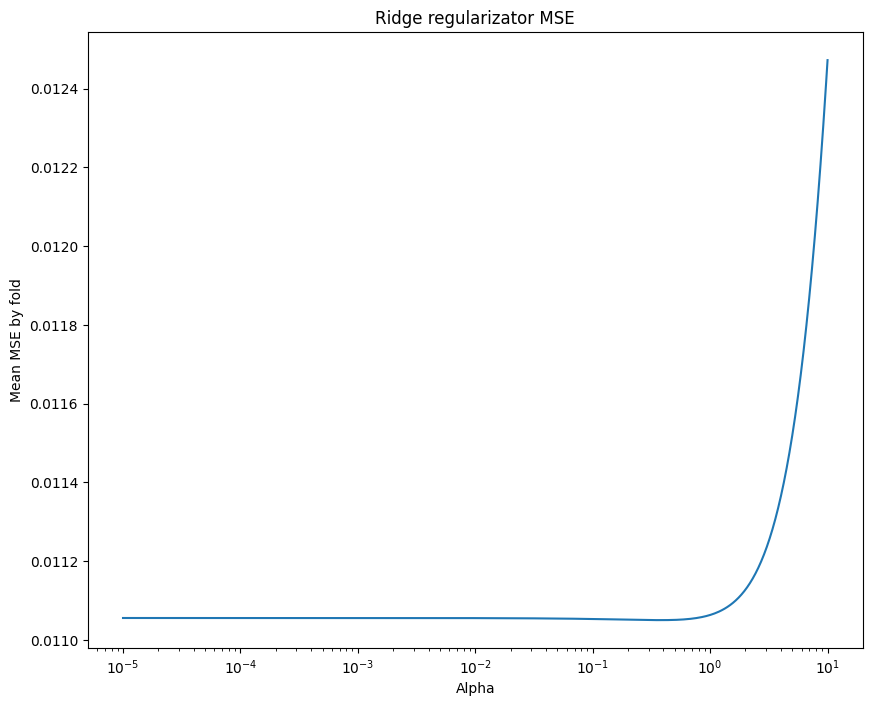

In [32]:
mean_mse_arr = np.array(reg.cv_values_).mean(axis=0)
plt.figure(figsize=(10, 8))
plt.semilogx(alphas_ridge, mean_mse_arr, label=feature )
plt.xlabel("Alpha")
plt.ylabel("Mean MSE by fold")
plt.title("Ridge regularizator MSE")
plt.show()

**Question 9.** What do you conclude?

We are not gaining much with lasso and ridge regression. The coefficients found by the two regularization strategies are rather similar. However, the accuracy is not great. It seems that the model is not able to make good predictions. More complex models should be tested.